In [30]:
import numpy as np
import pandas as pd
import os
import random
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import pathlib

from PIL import Image, ImageDraw


In [12]:
df = pd.read_json("./aircraft_training_data/planesnet.json")
df.head()

,data,labels,locations,scene_ids
0,"[206, 195, 187, 183, 177, 175, 174, 193, 198, ...",1,"[-118.40497658522878, 33.940618514147936]",20170620_175442_0e30
1,"[215, 209, 200, 196, 192, 197, 205, 168, 155, ...",1,"[-122.392469714, 37.6176425378]",20161212_180859_0e30
2,"[204, 214, 220, 219, 213, 205, 198, 193, 199, ...",1,"[-122.397578597, 37.6209247852]",20170524_181349_0e2f
3,"[179, 174, 179, 178, 173, 170, 168, 168, 168, ...",1,"[-122.214849831, 37.7203378331]",20161110_180707_0e1f
4,"[222, 222, 218, 214, 208, 205, 207, 206, 206, ...",1,"[-117.862173435, 33.6796854072]",20160813_184932_0c64


In [50]:
def get_image_path(row) -> pathlib.Path:
    """
    Generate the image path

    Args:
        row (_type_): pandas dataframe row

    Returns:
        Path: pathlib.Path
    """
    lat, lon = row['locations']
    image_type = "png"
    location_string = f"{lat}_{lon}"
    scene_id = row['scene_ids']
    is_airplane = row['labels']
    image_path = pathlib.Path(f"{os.getcwd()}/aircraft_training_data/planesnet/planesnet/{is_airplane}__{scene_id}__{location_string}.{image_type}")
    #C:\Users\faust\code\dev-aircraft-ident\aircraft_training_data\planesnet\planesnet\1__20170729_175335_101d__-118.40473405414056_33.945758062355.png
    return image_path

def get_image_data(row) -> np.array:
    try:
        image_path = row['image_path']
        i = Image.open(image_path)
        i = np.array(i)
        return i
    except FileNotFoundError as e:
        return np.nan


In [51]:
df['image_path'] = df.apply(get_image_path, axis=1)
df['image'] = df.apply(get_image_data, axis=1)

In [59]:
df.dropna(subset=['image'], inplace=True)
images = np.array(df.image.to_list())
labels = np.array(df.labels.to_list())

In [66]:
images[0].shape
labels[50:60]

array([1, 1, 1, ..., 0, 0, 0])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.25, random_state = 42)

In [68]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23863, 20, 20, 3)
(7955, 20, 20, 3)
(23863,)
(7955,)


In [69]:
#RESHAPING AND NORMALIZATION
X_train = X_train.astype('float32')
X_train = X_train.reshape(X_train.shape[0],20,20,3)
X_train = X_train / 255.

X_test = X_test.astype('float32')
X_test = X_test.reshape(X_test.shape[0], 20,20,3)
X_test = X_test / 255.

In [70]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D

# model architecture building
model_1 = Sequential()

model_1.add(BatchNormalization(input_shape = (20, 20, 3)))

model_1.add(Convolution2D(filters = 32, kernel_size = 3, activation ='relu', input_shape = (20, 20, 3))) 
model_1.add(MaxPooling2D(pool_size = 2))


model_1.add(Convolution2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = 2))

model_1.add(Flatten()) 

# fully connected layer
model_1.add(Dense(units = 64,activation = 'relu'))

# Classification layer
model_1.add(Dense(units = 1, activation = 'sigmoid')) 



In [73]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)
model_1.compile(optimizer=opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 20, 20, 3)         12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 18, 18, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 9, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                        

In [74]:
model = model_1.fit(X_train, y_train, epochs = 30, batch_size = 32, validation_data = (X_test, y_test),verbose=1)

Epoch 1/30
746/746 [==============================] - 6s 7ms/step - loss: 0.2744 - accuracy: 0.8908 - val_loss: 0.1904 - val_accuracy: 0.9282
Epoch 2/30
746/746 [==============================] - 5s 7ms/step - loss: 0.1580 - accuracy: 0.9431 - val_loss: 0.1350 - val_accuracy: 0.9500
Epoch 3/30
746/746 [==============================] - 5s 7ms/step - loss: 0.1219 - accuracy: 0.9544 - val_loss: 0.1164 - val_accuracy: 0.9565
Epoch 4/30
746/746 [==============================] - 5s 7ms/step - loss: 0.1068 - accuracy: 0.9591 - val_loss: 0.1209 - val_accuracy: 0.9550
Epoch 5/30
746/746 [==============================] - 5s 7ms/step - loss: 0.0945 - accuracy: 0.9653 - val_loss: 0.0971 - val_accuracy: 0.9647
Epoch 6/30
746/746 [==============================] - 5s 7ms/step - loss: 0.0869 - accuracy: 0.9676 - val_loss: 0.0930 - val_accuracy: 0.9664
Epoch 7/30
746/746 [==============================] - 5s 7ms/step - loss: 0.0804 - accuracy: 0.9704 - val_loss: 0.0951 - val_accuracy: 0.9640
Epoch 

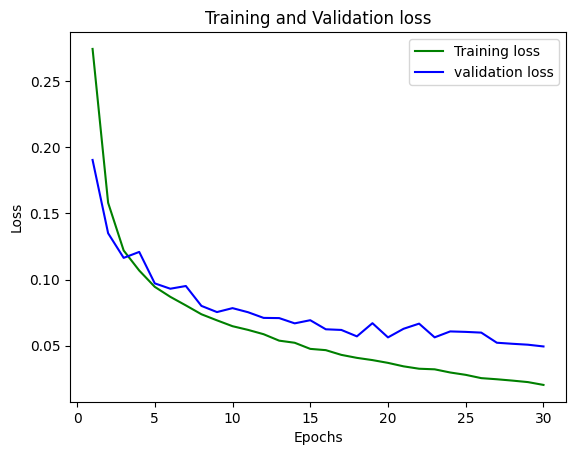

In [80]:
EPOCH=30
loss_train = model.history['loss']
loss_val = model.history['val_loss']
epochs = range(1,EPOCH+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

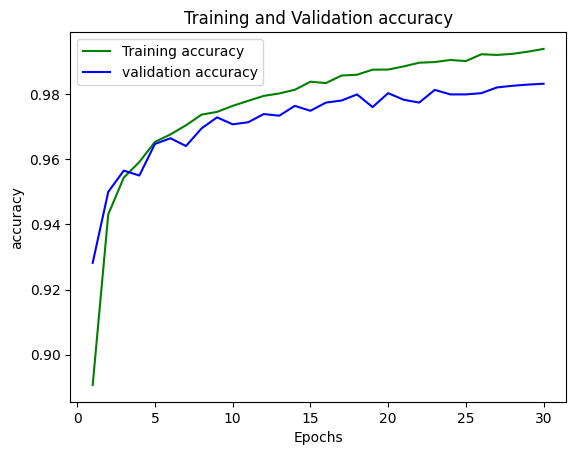

In [81]:
EPOCH=30
Acc_train = model.history['accuracy']
Acc_val = model.history['val_accuracy']
epochs = range(1,EPOCH+1)
plt.plot(epochs, Acc_train, 'g', label='Training accuracy')
plt.plot(epochs, Acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [83]:
model_1.evaluate(x=X_test, y=y_test, batch_size=200)

 1/40 [..............................] - ETA: 0s - loss: 0.0847 - accuracy: 0.9750

40/40 [==============================] - 0s 7ms/step - loss: 0.0494 - accuracy: 0.9832


[0.04938598349690437, 0.9831552505493164]

In [86]:
model_1.save("./model_001.keras")